# CNN 网络参数导出

本笔记本用于训练 CNN 模型并将参数导出到二进制文件中，以便于后续在 C 语言中使用。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 定义 CNN 模型
class CNN(nn.Module):
    def __init__(self):
        super().__init__() # -> 输入规格：1 x 28 x 28
        # 卷积层
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # -> 32 x 28 x 28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # -> 64 x 28 x 28
        self.pool = nn.MaxPool2d(2, 2)                           # 每次池化尺寸减半
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))              # -> (B, 32, 28, 28)
        x = self.pool(F.relu(self.conv2(x)))   # -> (B, 64, 14, 14)
        x = self.pool(x)                       # -> (B, 64, 7, 7)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)              # -> (B, 3136)
        x = F.relu(self.fc1(x))                # -> (B, 128)
        x = self.fc2(x)                        # -> (B, 10)
        return x

In [ ]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
])

# 加载 MNIST 数据集
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

# 加载可迭代对象DataLoader (可用loader.dataset访问原数据集)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device) # 将模型移动到GPU

# 设置优化器和损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:03<00:00, 2.92MB/s]



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 113kB/s]



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.12MB/s]



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 16.9MB/s]



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
# 训练模型
for epoch in range(1, 6): #遍历6次
    model.train() #模型切换到训练模式
    for batch_idx, (data, target) in enumerate(train_loader): 
    # data 是输入数据 target是监督的目标标签
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() #梯度清零
        output = model(data)  # 计算模型输出-> (B, 10)
        loss = criterion(output, target) # 计算损失
        loss.backward() # 反向传播
        optimizer.step() # 更新参数
    print(f"Epoch {epoch} 完成")

# 模型切换到验证模型
model.eval() 

correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        """
        .item() 是 PyTorch 张量(Tensor)的方法,用于将只包含一个元素的张量转换为对应的 Python 标量(如 int 或 float)。

        pred.eq(target)：比较预测和目标是否相等，返回布尔张量。
        .sum()：统计相等的数量，得到一个只包含一个元素的张量
        .item()：把这个单元素张量转换成 Python 的数字类型方便后续累加。
        
        如果张量有多个元素，.item() 会报错。它只能用于单元素张量。"""

print(f"\n测试准确率：{correct / len(test_loader.dataset):.4f}")

Epoch 1 完成
Epoch 2 完成
Epoch 2 完成
Epoch 3 完成
Epoch 3 完成
Epoch 4 完成
Epoch 4 完成
Epoch 5 完成
Epoch 5 完成

测试准确率：0.9925

测试准确率：0.9925


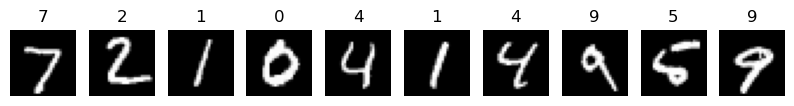

In [13]:
# 显示前10个预测结果
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    output = model(example_data.to(device))

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"{output[i].argmax().item()}")
    plt.axis('off')
plt.show()

## 导出CNN模型参数

接下来我们将导出模型的参数到二进制文件中

In [19]:
# 获取模型参数的state_dict
state_dict = model.state_dict()
print(state_dict.keys()) # 打印模型参数的名称

"""state_dict 本质上是一个 Python其中:
键(key):是字符串，表示参数的名称
值(value):是 tensor,包含实际的参数数据"""

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


'state_dict 本质上是一个 Python其中:\n键(key):是字符串，表示参数的名称\n值(value):是 tensor,包含实际的参数数据'

In [20]:
# 查看具体参数的形状
for key, value in state_dict.items():
    print(f"{key}: {value.shape}")

conv1.weight: torch.Size([32, 1, 3, 3])
conv1.bias: torch.Size([32])
conv2.weight: torch.Size([64, 32, 3, 3])
conv2.bias: torch.Size([64])
fc1.weight: torch.Size([128, 3136])
fc1.bias: torch.Size([128])
fc2.weight: torch.Size([10, 128])
fc2.bias: torch.Size([10])


In [ ]:
# 获取所有需要导出的参数
conv1_weight = state_dict['conv1.weight']
conv1_bias = state_dict['conv1.bias']
conv2_weight = state_dict['conv2.weight']
conv2_bias = state_dict['conv2.bias']
fc1_weight = state_dict['fc1.weight']
fc1_bias = state_dict['fc1.bias']
fc2_weight = state_dict['fc2.weight']
fc2_bias = state_dict['fc2.bias']

# 检查形状
print(f"conv1_weight: {conv1_weight.shape}")
print(f"conv1_bias: {conv1_bias.shape}")
print(f"conv2_weight: {conv2_weight.shape}")
print(f"conv2_bias: {conv2_bias.shape}")
print(f"fc1_weight: {fc1_weight.shape}")
print(f"fc1_bias: {fc1_bias.shape}")
print(f"fc2_weight: {fc2_weight.shape}")
print(f"fc2_bias: {fc2_bias.shape}")

conv1_weight: torch.Size([32, 1, 3, 3])
conv1_bias: torch.Size([32])
conv2_weight: torch.Size([64, 32, 3, 3])
conv2_bias: torch.Size([64])
fc1_weight: torch.Size([128, 3136])
fc1_bias: torch.Size([128])
fc2_weight: torch.Size([10, 128])
fc2_bias: torch.Size([10])


In [25]:
conv1_weight = conv1_weight.to('cpu')
conv1_bias = conv1_bias.to('cpu')
conv2_weight = conv2_weight.to('cpu')
conv2_bias = conv2_bias.to('cpu')
fc1_weight = fc1_weight.to('cpu')
fc1_bias = fc1_bias.to('cpu')
fc2_weight = fc2_weight.to('cpu')
fc2_bias = fc2_bias.to('cpu')

# 将参数导出到二进制文件
with open("parameters_cnn.bin", "wb") as out_bin:
    # 导出卷积层1的参数
    conv1_weight.numpy().astype(np.float32).tofile(out_bin)
    conv1_bias.numpy().astype(np.float32).tofile(out_bin)
    
    # 导出卷积层2的参数
    conv2_weight.numpy().astype(np.float32).tofile(out_bin)
    conv2_bias.numpy().astype(np.float32).tofile(out_bin)
    
    # 导出全连接层1的参数
    fc1_weight.numpy().astype(np.float32).tofile(out_bin)
    fc1_bias.numpy().astype(np.float32).tofile(out_bin)
    
    # 导出全连接层2的参数
    fc2_weight.numpy().astype(np.float32).tofile(out_bin)
    fc2_bias.numpy().astype(np.float32).tofile(out_bin)

print("参数成功导出到 parameters_cnn.bin 文件")

参数成功导出到 parameters_cnn.bin 文件


## 验证参数文件

检查二进制文件大小是否与参数数量一致

In [26]:
import os

# 计算参数总数
total_params = (
    conv1_weight.numel() + conv1_bias.numel() +
    conv2_weight.numel() + conv2_bias.numel() +
    fc1_weight.numel() + fc1_bias.numel() +
    fc2_weight.numel() + fc2_bias.numel()
)

# 检查文件大小
file_size = os.path.getsize("parameters_cnn.bin")
expected_size = total_params * 4  # 每个float32参数占4个字节

print(f"参数总数: {total_params}")
print(f"文件大小: {file_size} 字节")
print(f"预期大小: {expected_size} 字节")
print(f"大小是否匹配: {file_size == expected_size}")

参数总数: 421642
文件大小: 1686568 字节
预期大小: 1686568 字节
大小是否匹配: True
